In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from scipy import stats
from sklearn.mixture import GaussianMixture
import cartopy.crs as ccrs
import colormaps as clm
import matplotlib as mpl

# データの準備

In [14]:
train_val_path = "/docker/mnt/d/research/D2/cnn3/train_val/continuous/predictors_coarse_std_Apr_msot-pr_5x5_coarse_std_MJJASO_monsoon.pickle"
result_path = "/docker/mnt/d/research/D2/cnn3/result/continuous/monsoon/5x5/predictors_coarse_std_Apr_msot-pr_5x5_coarse_std_MJJASO_monsoon" \
              "/epoch100_batch256_seed1.npy"
with open(train_val_path, 'rb') as f:
    data = pickle.load(f)
x_train, y_train, x_val, y_val = data['x_train'], data['y_train'], data['x_val'], data['y_val']
pred = np.squeeze(np.load(result_path))

In [15]:
def GMM(data):
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.reshape(-1, 1))
    estimated_group = gmm.predict(data.reshape(-1, 1))
    return gmm

def separate(pred, y):
    rmse_flat = []
    for sam in range(len(y)):
        value = pred[:, sam]
        label = y[sam, :]
        rmse = np.sqrt(np.mean((value - label)**2))
        rmse_flat.append(rmse)
        
    rmse_flat = np.array(rmse_flat)
    gmm = GMM(rmse_flat)
    criteria = np.mean([gmm.means_[0, -1],
                        gmm.means_[1, -1]])
    
    true_index, false_index = [], []
    for sam in range(len(y)):
        if rmse_flat[sam] <= criteria:
            true_index.append(sam)
        else:
            false_index.append(sam)
        
    true_pred = pred[:, true_index]
    true_y = y[true_index, :]
    false_pred = pred[:, false_index]
    false_y = y[false_index, :]
    print(f"true pred{true_pred.shape}, false y{false_y.shape}")
    
    return true_pred, true_y, false_pred, false_y

In [16]:
true_pred, true_y, false_pred, false_y = separate(pred, y_val)

true pred(252, 851), false y(149, 252)


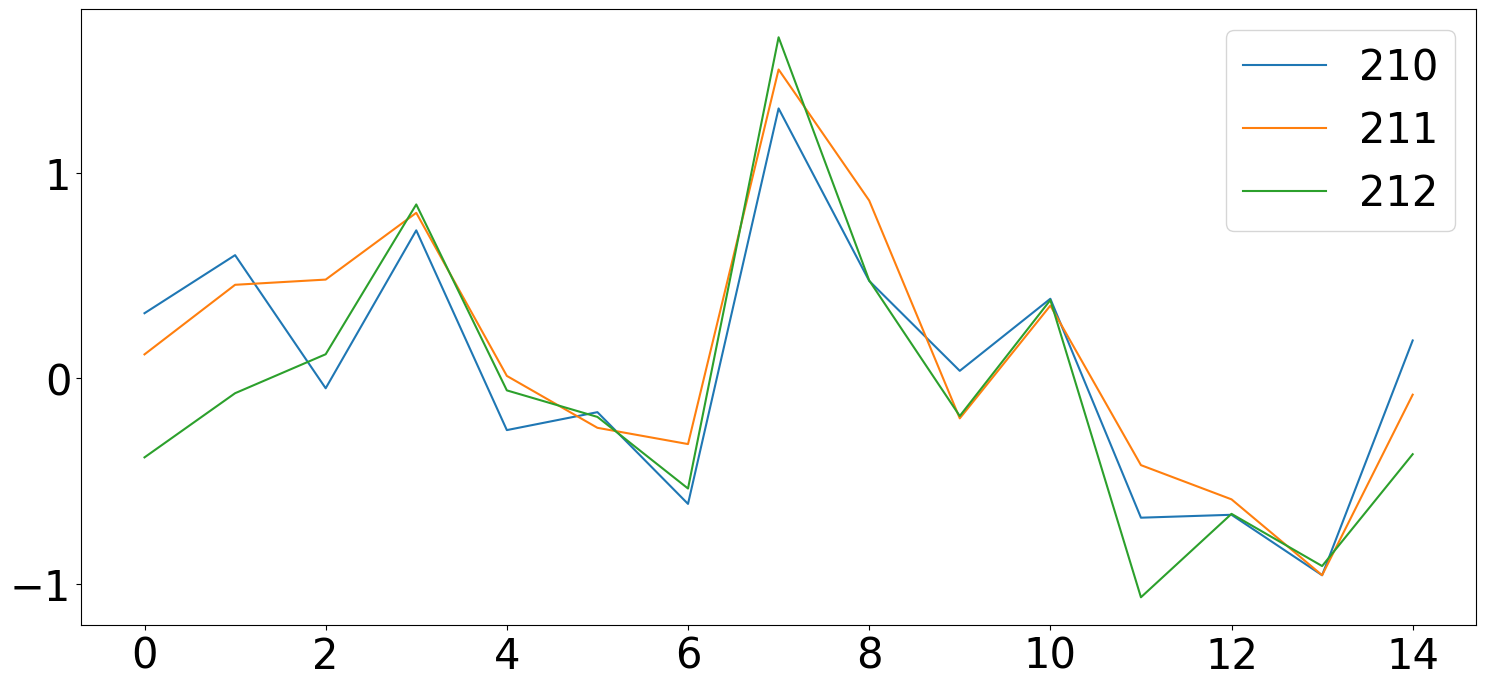

In [17]:
grid_list = [
             210,
             211,
             212,
            ]
fig, axes = plt.subplots(figsize=(18, 8))
for i in grid_list:
    plt.plot(true_pred[i, :15] ,label=f"{i}")
plt.legend()
plt.rcParams['font.size'] = 40
plt.show()

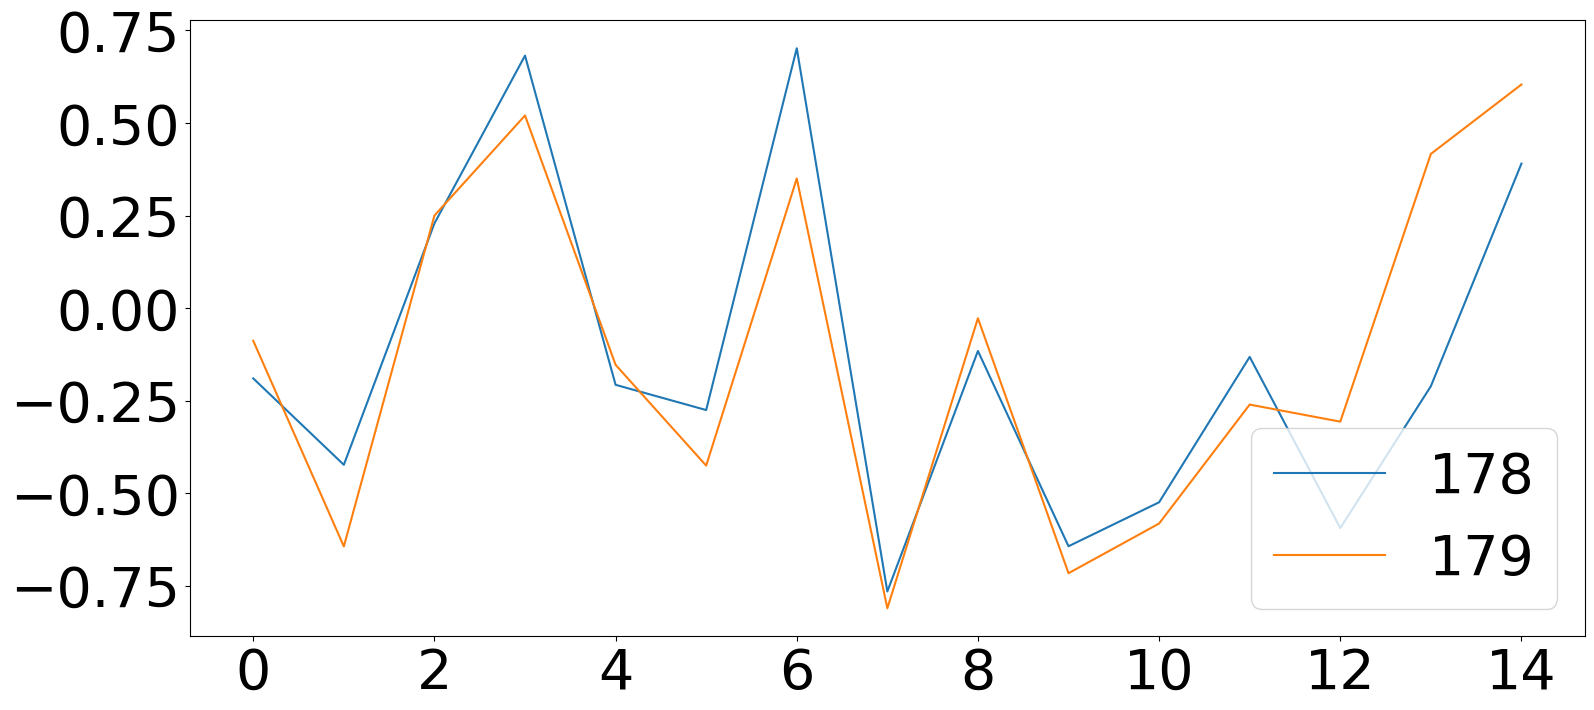

In [18]:
grid_list = [
             178,
             179,
            ]
fig, axes = plt.subplots(figsize=(18, 8))
for i in grid_list:
    plt.plot(true_pred[i, :15] ,label=f"{i}")
plt.legend()
plt.rcParams['font.size'] = 30
plt.show()

# 可視化

In [19]:
def draw_map(label, cluster_num=3):
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    cm = plt.cm.get_cmap('tab20', cluster_num)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(label,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

In [20]:
def plot_km(data, labels, km, cluster_num=3):
    fig, axes = plt.subplots(n, figsize=(8, 18))
    plt.subplots_adjust(hspace=0.5)
    for i in range(cluster_num):
        ax = axes[i]
        for xx in data[labels == i]:
            ax.plot(xx.ravel()[:10], "k-", alpha=.03)
        ax.plot(km.cluster_centers_[i].ravel()[:10], "r-")
    plt.show()

In [21]:
# shape needed (spatial pixel number, sample size)

print(y_train.shape, y_val.shape, true_y.shape, false_y.shape)

y_train_t, y_val_t, true_y_t, false_y_t = y_train.T, y_val.T, true_y.T, false_y.T
print(y_train_t.shape, y_val_t.shape, true_y_t.shape, false_y_t.shape)

(5930, 252) (1000, 252) (851, 252) (149, 252)
(252, 5930) (252, 1000) (252, 851) (252, 149)


In [22]:
n = 3 # クラスタ数

km_dtw = TimeSeriesKMeans(n_clusters=n,
                          random_state=42,
                          metric="dtw")

# calc done

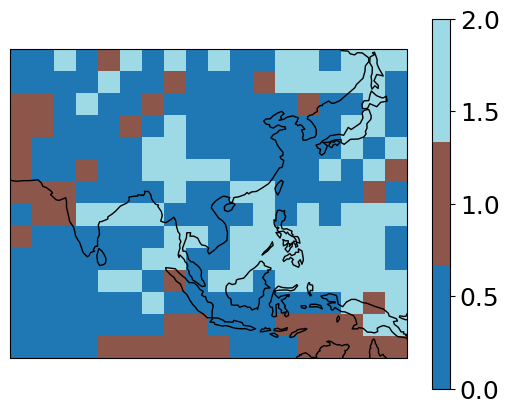

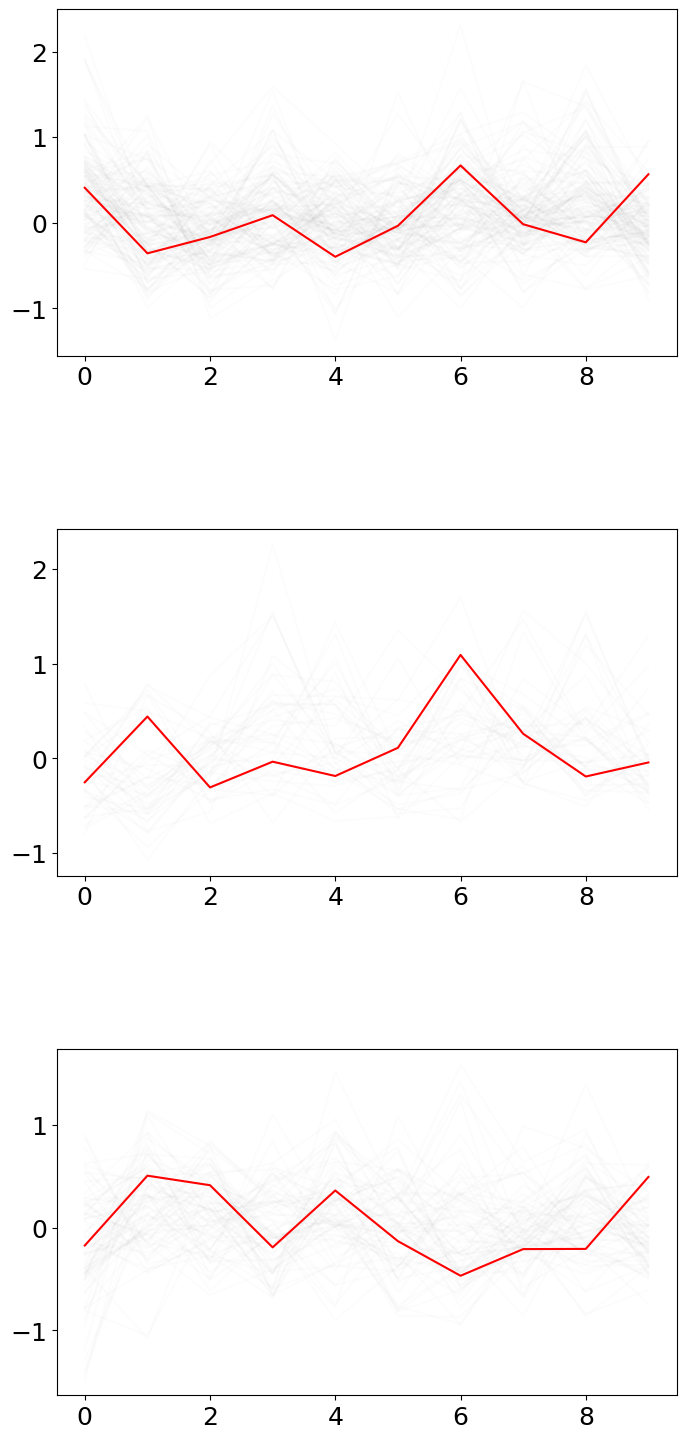

In [75]:
# false_y

false_labels = km_dtw.fit_predict(false_y_t)
false_flat = false_labels[:]
false_map = np.reshape(false_flat, (14, 18))

draw_map(false_map, cluster_num=n)
plot_km(false_y_t, false_labels, km_dtw, cluster_num=n)

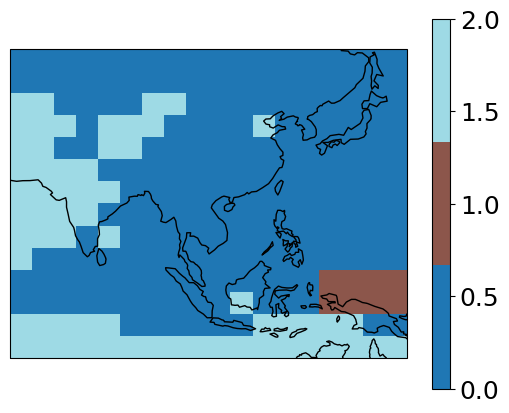

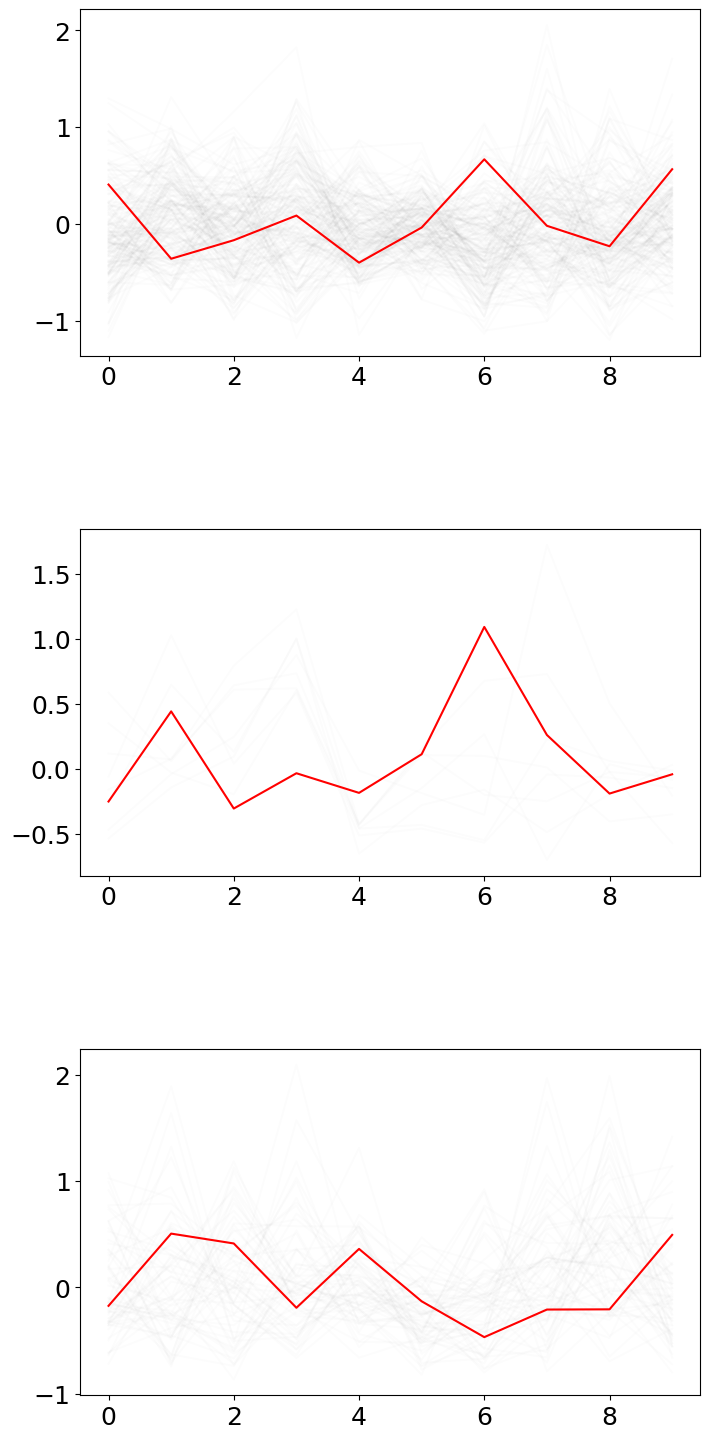

In [76]:
# true_y

"""
true_labels = km_dtw.fit_predict(true_y_t)
true_flat = true_labels[:]
true_map = np.reshape(true_flat, (14, 18))
"""

draw_map(true_map, cluster_num=n)
plot_km(true_y_t, true_labels, km_dtw, cluster_num=n)

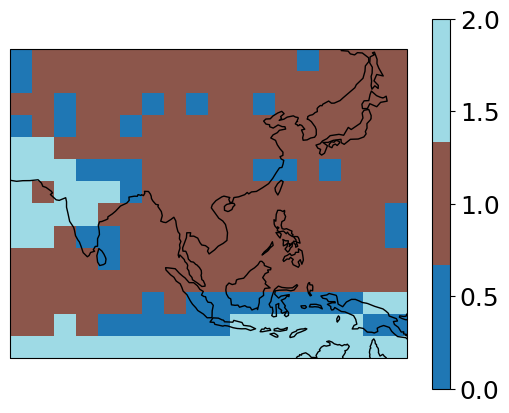

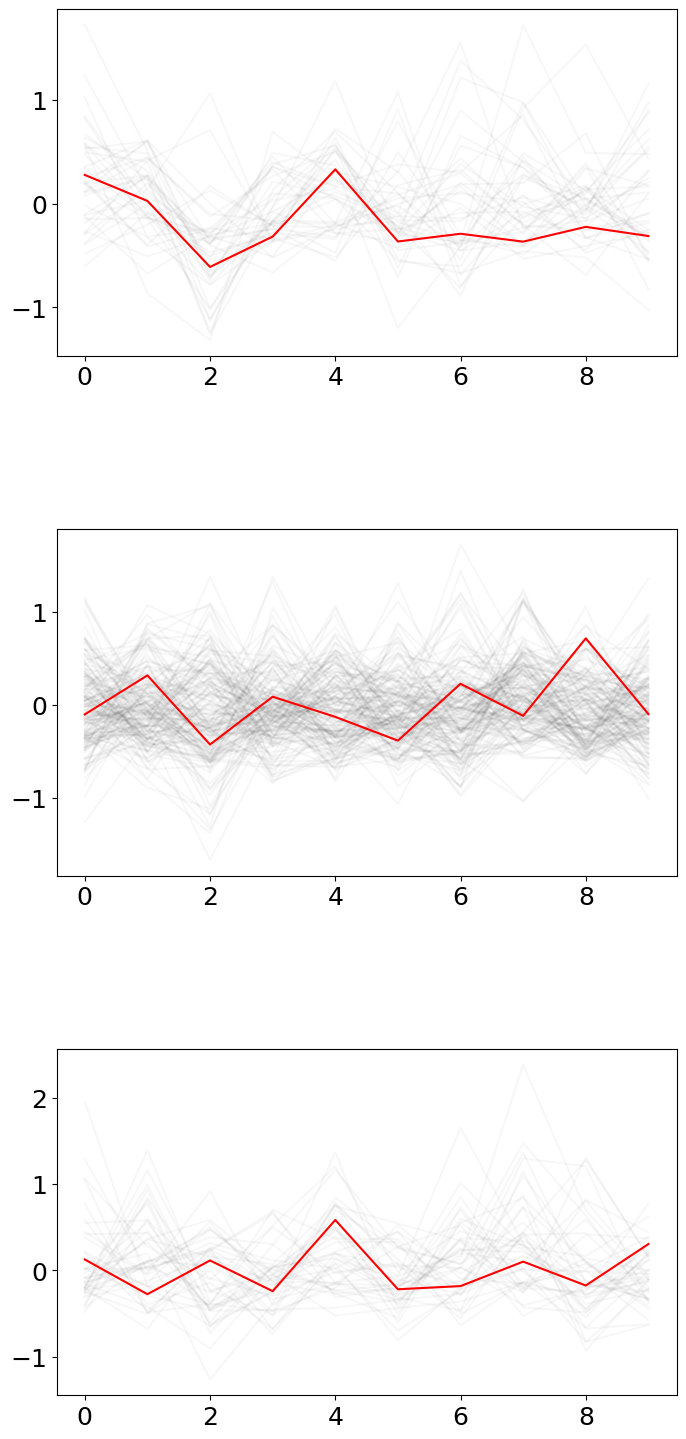

In [25]:
# y_train
y_train_t = y_train_t[:, :5000]

train_labels = km_dtw.fit_predict(y_train_t)
train_flat = train_labels[:]
train_map = np.reshape(train_flat, (14, 18))

draw_map(train_map, cluster_num=n)
plot_km(y_train_t, train_labels, km_dtw, cluster_num=n)

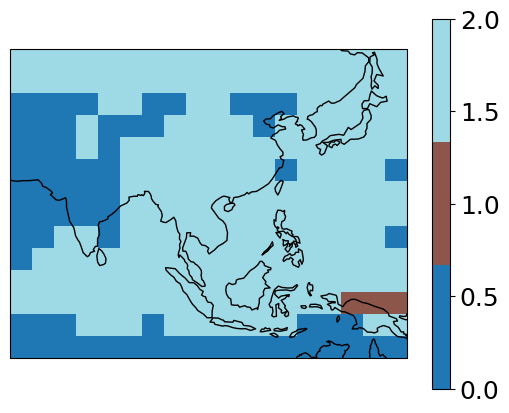

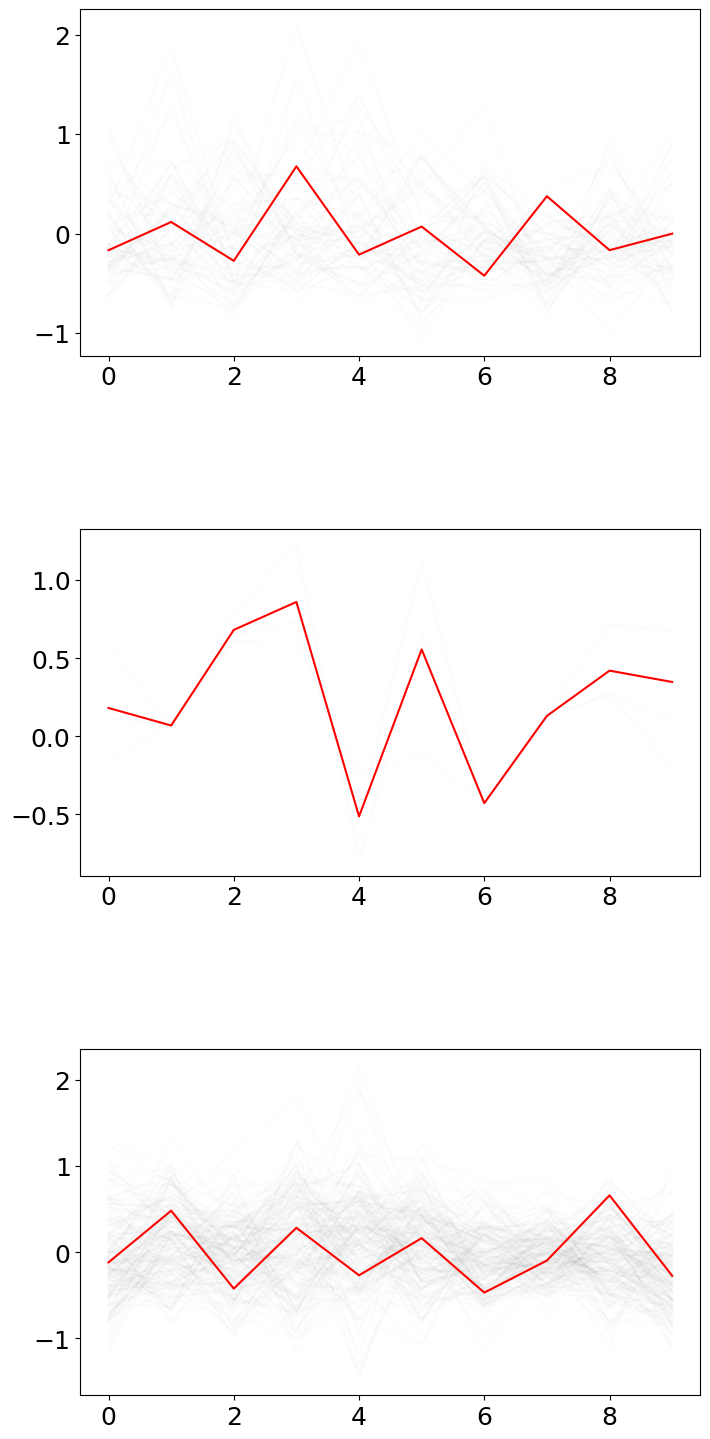

In [77]:
# y_val

val_labels = km_dtw.fit_predict(y_val_t)
val_flat = val_labels[:]
val_map = np.reshape(val_flat, (14, 18))

draw_map(val_map, cluster_num=n)
plot_km(y_val_t, val_labels, km_dtw, cluster_num=n)